In [161]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import util
import dinuc_shuffle
import pandas as pd
import pysam
import kipoiseq
import numpy as np
from scipy.spatial import distance
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import util
import upsetplot 
from matplotlib_venn import venn2
from upsetplot import generate_counts
from upsetplot import from_memberships
import pybedtools
import pyBigWig
from scipy.stats import pearsonr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
fasta_extractor = util.FastaStringExtractor('../../genomes/hg38.fa')


In [ ]:

def get_js_per_seq(x, y):
    """
    Function to calculate per sequence JS distance
    :param x: array 1
    :param y: array 2
    :return: JS distance along dim 1
    """
    pseudocount = np.finfo(float).eps
    norm_arrays = []
    for array in [x, y]:
        array = np.clip(array, 0, array.max())
        array += pseudocount
        norm_array = array / array.sum()
        norm_arrays.append(norm_array)
    return distance.jensenshannon(norm_arrays[0], norm_arrays[1])

In [4]:
regulon = pd.read_csv('/gstore/home/toneyans/regulon.csv')

In [5]:
gata6_re = regulon[regulon['tf'] == 'GATA6'][['chr', 'start', 'end']]

nkx_re = regulon[regulon['tf'] == 'NKX2-1'][['chr', 'start', 'end']]

In [61]:
gata6_re.to_csv('gata6.csv', sep='\t', header=None, index=None)
nkx_re.to_csv('nkx.csv', sep='\t', header=None, index=None)

In [ ]:
gata = pybedtools.BedTool('./gata6.csv')
nkx = pybedtools.BedTool('nkx.csv')
c1 = pybedtools.BedTool('/gstore/project/lineage/shush/CBP_Epiregulon/training_data/peaks/C1_peaks.bed')
c3 = pybedtools.BedTool('/gstore/project/lineage/shush/CBP_Epiregulon/training_data/peaks/C3_peaks.bed')


In [100]:
gata_and_nkx = gata.intersect(nkx)


3028

In [104]:
import itertools

def unique_combinations(elements, N):
    return list(itertools.combinations(elements, N))

In [165]:
label_list = []
value_list = []
bed_dict = {'GATA6': gata, 'NKX2-1': nkx, 'C1 peaks': c1, 'C3 peaks': c3}
for a, b in unique_combinations(bed_dict.keys(), 2):
    N_int = len(bed_dict[a].intersect(bed_dict[b]))
    N_a = len(bed_dict[a])
    N_b = len(bed_dict[b])
    for i, element in enumerate([[a], [b], [a, b]]):
        if element not in label_list:
            label_list.append(element)
            value_list.append([N_a, N_b, N_int][i])
            
for a, b, c in unique_combinations(bed_dict.keys(), 3):
    N_int = len(bed_dict[a].intersect(bed_dict[b]).intersect(bed_dict[c]))
    N_a = len(bed_dict[a])
    N_b = len(bed_dict[b])
    N_c = len(bed_dict[c])
    for i, element in enumerate([[a], [b], [c], [a, b, c]]):
        if element not in label_list:
            label_list.append(element)
            value_list.append([N_a, N_b, N_c, N_int][i])



In [166]:
data = from_memberships(label_list, data=value_list)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

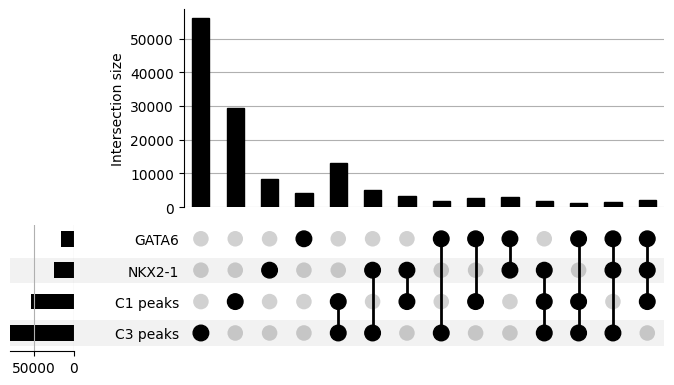

In [170]:
upsetplot.plot(data)

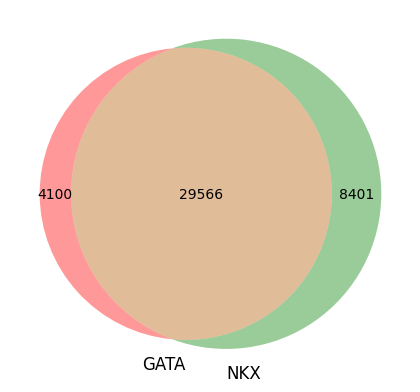

In [116]:
N_a, N_b, N_c = len(gata), len(nkx), len(c1)
N_int = len(gata.intersect(nkx).intersect(c1))
venn2(subsets = (N_a, N_b, N_c, N_int), set_labels = ('GATA', 'NKX', 'C1'))


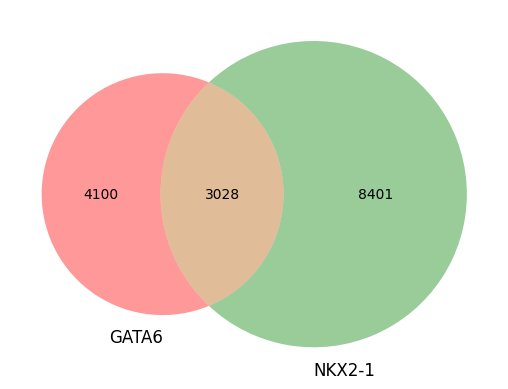

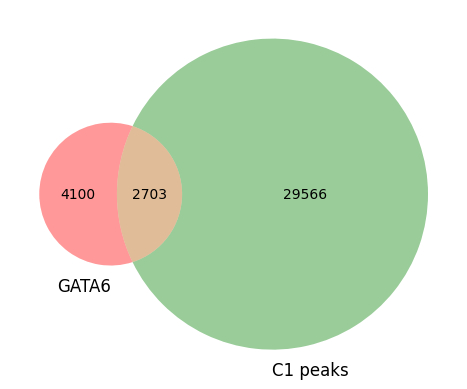

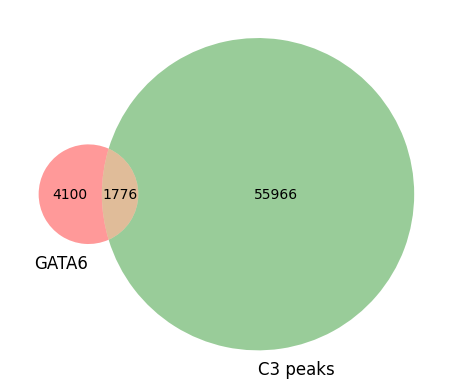

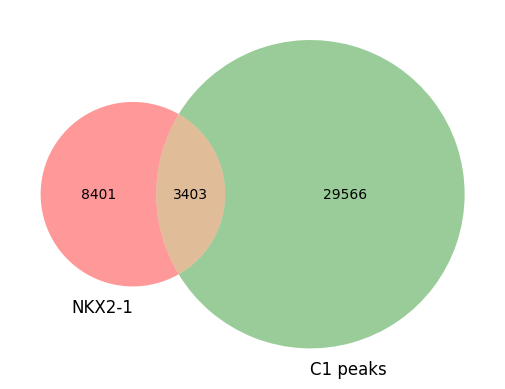

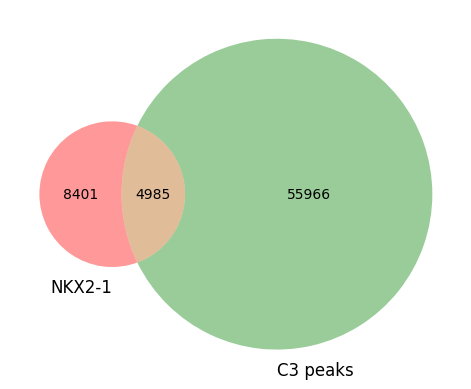

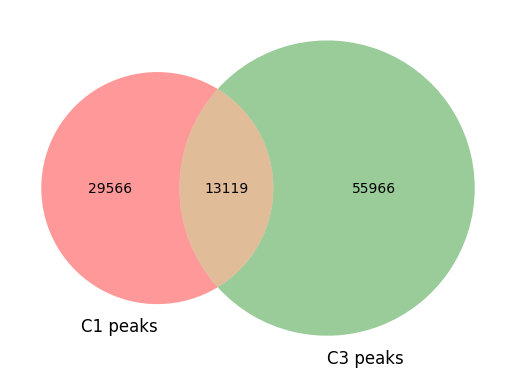

In [115]:
bed_dict = {'GATA6': gata, 'NKX2-1': nkx, 'C1 peaks': c1, 'C3 peaks': c3}
for a, b in unique_combinations(bed_dict.keys(), 2):
    N_int = len(bed_dict[a].intersect(bed_dict[b]))
    N_a = len(bed_dict[a])
    N_b = len(bed_dict[b])
    venn2(subsets = (N_a, N_b, N_int), set_labels = (a, b))
    plt.show()
    

In [55]:

for label, df in {'gata6':gata6_re, 'nkx':nkx_re}.items():
    for model_path in ['../doubletRemoved_models/C3_chrombpnet_nobias.h5',
                       '../doubletRemoved_models/C1_chrombpnet_nobias.h5']:

        results = util.perturb_seqs(df, model_path, fasta_extractor, 2114, 'dinuc', f'../results/{label}')


N rows = 4100


4100it [04:12, 16.24it/s]


N rows = 4100


4100it [03:28, 19.66it/s]


N rows = 8401


8401it [07:34, 18.48it/s]


N rows = 8401


8401it [06:55, 20.22it/s]


In [275]:
result_summaries_list = []
for tf in ['gata6', 'nkx']:
    for model in ['C1', 'C3']:
        results = util.dict_load(f'../results/{tf}_model_{model}_chrombpnet_nobias_10_dinuc.pickle')
        for output in ['profile', 'count', 'profile x count']:
            for perturb in ['wt', 'dishuffled']:
                if output == 'profile x count':
                    vals = np.max(results[f'{perturb}_profile'], axis=-1) * results[f'{perturb}_count']
                else:
                    vals = results[f'{perturb}_{output}']
                    if output == 'profile':
                    
                        vals = np.mean(vals, axis=-1)
                    
                df = pd.DataFrame({'value': vals})
                df['TF'] = tf
                df['model'] = model
                df['output'] = output
                df['perturb'] = perturb
                df = df.reset_index()
                result_summaries_list.append(df)
result_summaries = pd.concat(result_summaries_list)

In [276]:
result_summaries_list[-1]

,index,value,TF,model,output,perturb
0,0,-0.929396,nkx,C3,profile x count,dishuffled
1,1,-1.284523,nkx,C3,profile x count,dishuffled
2,2,-3.089794,nkx,C3,profile x count,dishuffled
3,3,-2.944581,nkx,C3,profile x count,dishuffled
4,4,-2.092691,nkx,C3,profile x count,dishuffled
...,...,...,...,...,...,...
8396,8396,-1.348293,nkx,C3,profile x count,dishuffled
8397,8397,0.417722,nkx,C3,profile x count,dishuffled
8398,8398,-0.146134,nkx,C3,profile x count,dishuffled
8399,8399,-3.044002,nkx,C3,profile x count,dishuffled


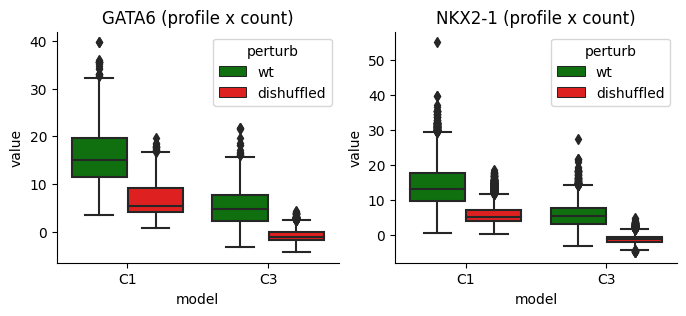

In [238]:
fig, axes = plt.subplots(1, 2, figsize=[8,3])
output = 'profile x count'
tf_label = {'gata6': 'GATA6', 'nkx': 'NKX2-1'}

for t, tf in enumerate(['gata6', 'nkx']):
    ax = axes[t]
    df = result_summaries[(result_summaries['TF']==tf) 
                          # & (result_summaries['model']=='C1') 
                          & (result_summaries['output']==output)
                         ]
    sns.boxplot(df, x='model', y='value', hue='perturb', ax=ax, palette=['g', 'r'])
    ax.set_title(f'{tf_label[tf]} ({output})')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


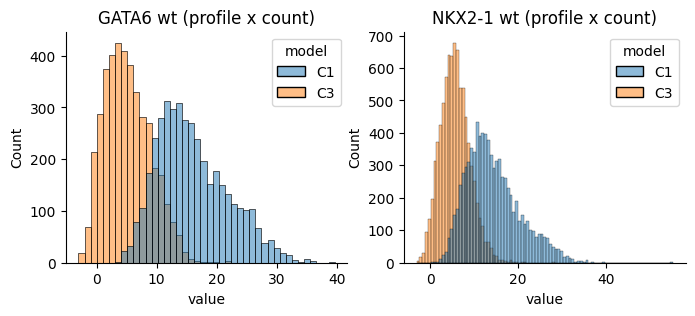

In [235]:
fig, axes = plt.subplots(1, 2, figsize=[8,3])
output = 'profile x count'
perturb = 'wt'
tf_label = {'gata6': 'GATA6', 'nkx': 'NKX2-1'}
for t, tf in enumerate(['gata6', 'nkx']):
    ax = axes[t]
    df = result_summaries[(result_summaries['TF']==tf) 
                          & (result_summaries['perturb']==perturb) 
                          & (result_summaries['output']==output)
                         ]
    sns.histplot(df, x='value', hue='model', ax=ax)
    ax.set_title(f'{tf_label[tf]} {perturb} ({output})')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [252]:
ratio_df

,value,model
0,1.745435,C1
1,1.597205,C1
2,2.569951,C1
3,2.180899,C1
4,2.105163,C1
...,...,...
16797,-3.118440,C3
16798,19.060425,C3
16799,-29.838989,C3
16800,0.080931,C3


/local/10124538/ipykernel_27871/2556126152.py:14: RuntimeWarning: invalid value encountered in log
  ratio_df = pd.DataFrame({'value': np.log(df_wt / df_shuffle), 'model': df[df['perturb']=='wt']['model'].values})
/local/10124538/ipykernel_27871/2556126152.py:14: RuntimeWarning: invalid value encountered in log
  ratio_df = pd.DataFrame({'value': np.log(df_wt / df_shuffle), 'model': df[df['perturb']=='wt']['model'].values})


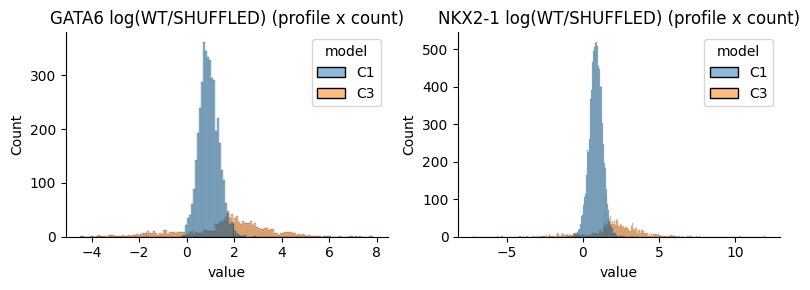

In [340]:
fig, axes = plt.subplots(1, 2, figsize=[8,3])
output = 'profile x count'

tf_label = {'gata6': 'GATA6', 'nkx': 'NKX2-1'}
for t, tf in enumerate(['gata6', 'nkx']):
    ax = axes[t]
    df = result_summaries[(result_summaries['TF']==tf) 
                          & (result_summaries['output']==output)
                         ]

    df_wt = df[df['perturb']=='wt']['value'].values
    df_shuffle = df[df['perturb']=='dishuffled']['value'].values
    
    ratio_df = pd.DataFrame({'value': np.log(df_wt / df_shuffle), 'model': df[df['perturb']=='wt']['model'].values})
    sns.histplot(ratio_df, x='value', hue='model', ax=ax)
    ax.set_title(f'{tf_label[tf]} log(WT/SHUFFLED) ({output})')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()

In [330]:
df[df['perturb']=='wt'].iloc[5241]

index                 5241
value             2.686167
TF                     nkx
model                   C1
output     profile x count
perturb                 wt
Name: 5241, dtype: object

In [331]:
results = util.dict_load(f'../results/nkx_model_C1_chrombpnet_nobias_10_dinuc.pickle')

2.686166653544774
2.6870152204300837


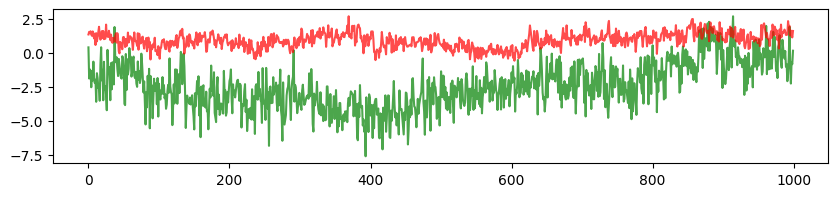

In [332]:
plt.figure(figsize=[10, 2])
colors = ['g', 'r']
for p, perturb in enumerate(['wt', 'dishuffled']):
    X = results[f'{perturb}_profile'][5241] * results[f'{perturb}_count'][5241]
    print(X.max())
    plt.plot(X, label=perturb, c=colors[p], alpha=0.7)


In [325]:
np.log(9.045054106802581 / 5.642986370898301e-05)

11.984730141995376

In [322]:
ratio_df['value'][14864]

11.984730141995376

In [329]:
np.nanargmin(np.abs(ratio_df['value'].values))

5241

4100it [00:01, 3320.22it/s]
/gstore/home/toneyans/anaconda3/envs/cbp/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gstore/home/toneyans/anaconda3/envs/cbp/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
8401it [00:02, 3356.74it/s]
/gstore/home/toneyans/anaconda3/envs/cbp/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gstore/home/toneyans/anaconda3/envs/cbp/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


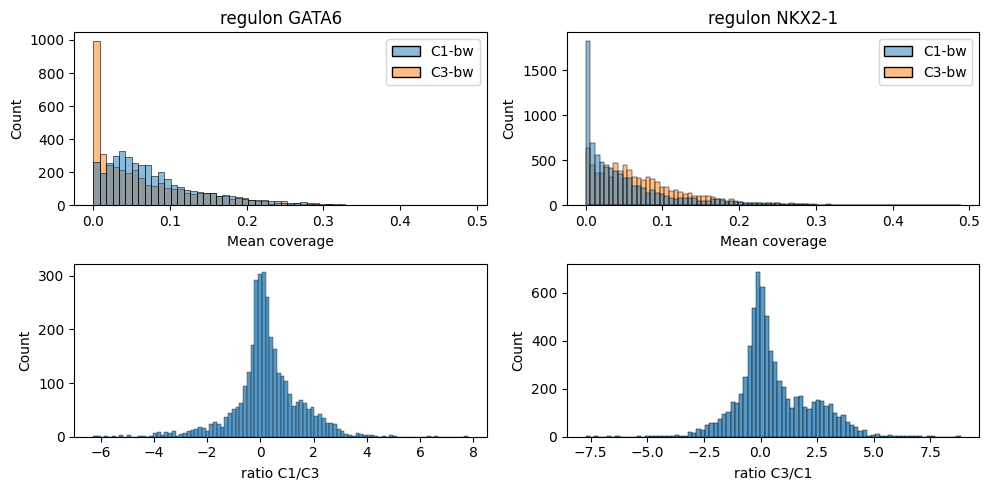

In [34]:
c1_bw = pyBigWig.open('/gstore/project/ar_ligands/NE/reprogram_seq/multiome_arrayed/OUTPUT/doubletremoved/GroupBigWigs/Clusters/C1-TileSize-100-normMethod-ReadsInTSS-ArchR.bw')
c3_bw = pyBigWig.open('/gstore/project/ar_ligands/NE/reprogram_seq/multiome_arrayed/OUTPUT/doubletremoved/GroupBigWigs/Clusters/C3-TileSize-100-normMethod-ReadsInTSS-ArchR.bw')

fig, axes = plt.subplots(2,2, figsize=[10, 5])

for i, (tf, df) in enumerate({"GATA6": gata6_re, "NKX2-1": nkx_re}.items()):
    re_gt = {'C1-bw':[], 'C3-bw':[]}

    for _, row in tqdm(df.iterrows()):
        re_gt['C1-bw'].append(np.mean(c1_bw.values(row[0], int(row[1]), int(row[2]))))
        re_gt['C3-bw'].append(np.mean(c3_bw.values(row[0], int(row[1]), int(row[2]))))
    re_gt = pd.DataFrame(re_gt)
    
    sns.histplot(data=re_gt.melt(var_name='', value_name='Mean coverage'), x='Mean coverage', hue='', ax=axes[0][i])
    axes[0][i].set_title("regulon "+tf)
    re_gt['ratio C1/C3'] = np.log(re_gt['C1-bw'] / re_gt['C3-bw'])
    re_gt['ratio C3/C1'] = np.log(re_gt['C3-bw'] / re_gt['C1-bw'])
    if tf == 'GATA6':
        sns.histplot(data=re_gt, x='ratio C1/C3', ax=axes[1][i])
    if tf == 'NKX2-1':
        sns.histplot(data=re_gt, x='ratio C3/C1', ax=axes[1][i])

    plt.tight_layout()
    
c1_bw.close()
c3_bw.close()

# Motif based shuffle

In [45]:
c1_motifs = pd.read_csv('/gstore/project/lineage/shush/CBP_Epiregulon/motifs_in_peaks/C1_Motifs.bed', sep='\t', header=None)

In [ ]:
c3_motifs = pd.read_csv('/gstore/project/lineage/shush/CBP_Epiregulon/motifs_in_peaks/C1_Motifs.bed', sep='\t', header=None)

In [53]:
GATA_mask = [True if 'GATA' in f else False  for f in c1_motifs[3] ]

In [ ]:
[f for f in c1]

In [55]:
c1_gata = c1_motifs[GATA_mask]

In [57]:

for label, df in {'gata6_motif_in_c1':c1_gata}.items():
    for model_path in ['../doubletRemoved_models/C3_chrombpnet_nobias.h5',
                       '../doubletRemoved_models/C1_chrombpnet_nobias.h5']:

        results = util.perturb_seqs(df, model_path, fasta_extractor, 2114, 'dinuc', f'../results/{label}')


N rows = 10288


10288it [10:43, 15.99it/s]


N rows = 10288


10288it [09:26, 18.17it/s]


In [166]:
summary = {}
for tf in ['gata6_motif_in_c1']:
    for model in ['C1', 'C3']:
        summary[model] = {}
        summary[model]['JS'] = []
        summary[model]['wt'] = []
        summary[model]['sh'] = []
        summary[model]['PCC'] = []
        results = util.dict_load(f'../results/{tf}_model_{model}_chrombpnet_nobias_10_dinuc.pickle')
        for i in tqdm(range(len(results['wt_count']))):
            wt_pred = results['wt_profile'][i] * results[f'wt_count'][i]
            sh_pred = results['dishuffled_profile'][i] * results[f'dishuffled_count'][i]
            summary[model]['wt'].append(np.max(wt_pred))
            summary[model]['sh'].append(np.max(sh_pred))
            summary[model]['JS'].append(get_js_per_seq(wt_pred, sh_pred))
            summary[model]['PCC'].append(pearsonr(wt_pred, sh_pred)[0])
                    

# result_summaries = pd.concat(result_summaries_list)

  0%|          | 0/10288 [00:00<?, ?it/s]/gstore/home/toneyans/anaconda3/envs/cbp/lib/python3.9/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|██████████| 10288/10288 [00:10<00:00, 993.23it/s] 


<Axes: ylabel='Count'>

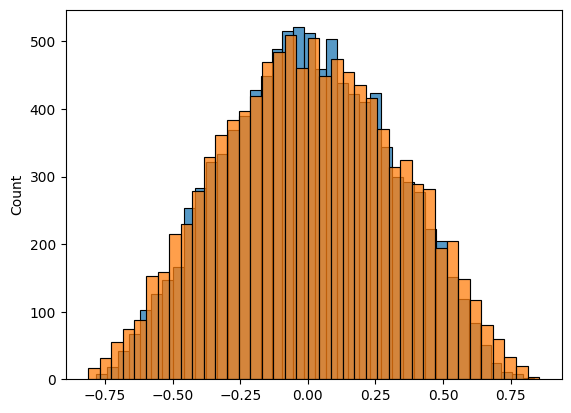

In [167]:
sns.histplot(x=summary['C1']['PCC'])
sns.histplot(x=summary['C3']['PCC'])

In [155]:
df = pd.DataFrame([summary['C1']['wt'], summary['C1']['sh'], 
              summary['C3']['wt'], summary['C3']['sh']]).T
df.columns = ['C1 model WT', 'C1 model shuffled', 'C3 model WT', 'C3 model shuffled']

<Axes: xlabel='variable', ylabel='value'>

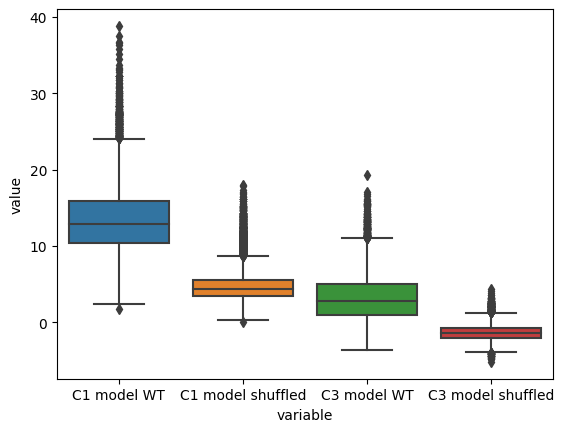

In [160]:
sns.boxplot(data=df.melt(), x='variable', y='value')

Text(0.5, 1.0, 'GATA6 in C1 peaks')

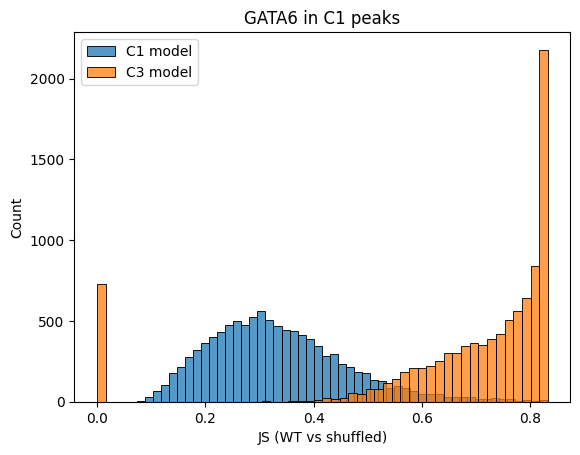

In [130]:
sns.histplot(x=summary['C1'], label='C1 model')
sns.histplot(x=summary['C3'], label='C3 model')
plt.legend()
plt.xlabel('JS (WT vs shuffled)')
plt.title('GATA6 in C1 peaks')

In [140]:
m_js = np.nanargmin(np.array(summary['C3']))

In [148]:
c1_gata.iloc[m_js]

0                 chr1
1             10780167
2             10780182
3    GATA3.Zf..DR4_103
4                    .
5                    -
Name: 317068, dtype: object

In [127]:
results = util.dict_load(f'../results/gata6_motif_in_c1_model_C3_chrombpnet_nobias_10_dinuc.pickle')


Text(0, 0.5, 'Prediction')

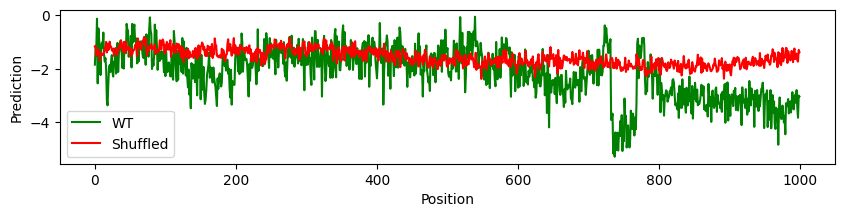

In [141]:
plt.figure(figsize=[10,2])
plt.plot(results['wt_profile'][m_js], label='WT', c='g')
plt.plot(results['dishuffled_profile'][m_js], label='Shuffled', c='r')
plt.legend()
plt.xlabel('Position')
plt.ylabel('Prediction')

0.4586017047040576

In [96]:
sh_pred.shape

(1000,)